In [ ]:
import pickle
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Constants
USE_SUBLABEL = False
URL_PER_SITE = 10
TOTAL_URLS_MONITORED = 950
TOTAL_URLS_UNMONITORED = 3000

# Load monitored data
print("Loading monitored datafile...")
with open("./mon_standard.pkl", 'rb') as fi:
    monitored_data = pickle.load(fi)

X1_mon, X2_mon, y_mon = [], [], []
for i in range(TOTAL_URLS_MONITORED):
    label = i // URL_PER_SITE
    for sample in monitored_data[i]:
        size_seq = []
        time_seq = []
        for c in sample:
            dr = 1 if c > 0 else -1
            time_seq.append(abs(c))
            size_seq.append(dr * 512)
        X1_mon.append(time_seq)
        X2_mon.append(size_seq)
        y_mon.append(label)
mon_size = len(y_mon)

print(f'Total monitored samples: {mon_size}') # Output: 19000


Loading monitored datafile...
Total monitored samples: 19000


In [ ]:
# Load unmonitored data
print("Loading unmonitored datafile...")
with open('./unmon_standard10_3000.pkl', 'rb') as f:
    unmonitored_data = pickle.load(f)

X1_unmon = [] # Array to store instances (timestamps)
X2_unmon = [] # Array to store instances (direction*size)
y_unmon = [] # Array to store the site of each instance

for i in range(TOTAL_URLS_UNMONITORED):
    size_seq = []
    time_seq = []
    for c in unmonitored_data[i]:
        dr = 1 if c > 0 else -1
        time_seq.append(abs(c))
        size_seq.append(dr * 512)
    X1_unmon.append(time_seq)
    X2_unmon.append(size_seq)
    y_unmon.append(-1)
unmon_size = len(y_unmon)

print(f'Total unmonitored samples: {unmon_size}') # Output: 3000

Loading unmonitored datafile...
Total unmonitored samples: 3000


In [5]:
# Create the DataFrame from monitored data
df_mon = pd.DataFrame({
    'time_seq': X1_mon,
    'size_seq': X2_mon,
    'label': y_mon
})
df_unmon = pd.DataFrame({
    'time_seq': X1_unmon,
    'size_seq': X2_unmon,
    'label': y_unmon
})

# Check if the dataframe is created properly
print(f"monitored dataFrame size: {df_mon.shape}")
print(f"unmonitored dataFrame size: {df_unmon.shape}")

monitored dataFrame size: (19000, 3)
unmonitored dataFrame size: (3000, 3)


In [6]:
# Combine monitored and unmonitored data
df_combined = pd.concat([df_mon, df_unmon], ignore_index=True)


# Check if the DataFrame is created properly
print(f"Combined DataFrame size: {df_combined.shape}")

Combined DataFrame size: (22000, 3)


In [7]:
# Extract Continuous Features
df_combined['cumulative_size'] = df_combined['size_seq'].apply(np.cumsum)
df_combined['burst_std'] = df_combined['size_seq'].apply(lambda x: np.std(np.diff(x, prepend=0)))
df_combined['mean_packet_size'] = df_combined['size_seq'].apply(np.mean)
df_combined['mean_timestamp'] = df_combined['time_seq'].apply(np.mean)

# Extract Categorical Features
df_combined['num_incoming'] = df_combined['size_seq'].apply(lambda x: sum(1 for i in x if i < 0))
df_combined['num_outgoing'] = df_combined['size_seq'].apply(lambda x: sum(1 for i in x if i > 0))
df_combined['fraction_incoming'] = df_combined['num_incoming'] / (df_combined['num_incoming'] + df_combined['num_outgoing'])
df_combined['fraction_outgoing'] = df_combined['num_outgoing'] / (df_combined['num_incoming'] + df_combined['num_outgoing'])
df_combined['total_packets'] = df_combined['num_incoming'] + df_combined['num_outgoing']

# Add Features
df_combined['packetsize_std'] = df_combined['size_seq'].apply(lambda x: np.std(x))
df_combined['timestamp_std'] = df_combined['time_seq'].apply(lambda x: np.std(x))
df_combined['mean_outgoing_packets'] = df_combined['size_seq'].apply(lambda x: np.mean([i for i in x if i > 0]) if any(i > 0 for i in x) else 0)
df_combined['packet_concentration_ordering'] = df_combined['size_seq'].apply(lambda x: np.mean(np.diff(x)))

# Fill NaN values (if any)
df_combined.fillna(0, inplace=True)

In [8]:
continuous_features = [
    'cumulative_size', 'burst_std', 'mean_packet_size', 'mean_timestamp',
    'packetsize_std', 'timestamp_std']
categorical_features = ['fraction_incoming', 'fraction_outgoing', 'total_packets', 'num_incoming', 'num_outgoing',
                        'mean_outgoing_packets', 'packet_concentration_ordering']

# Flatten lists
X_continuous = np.array(df_combined[continuous_features].map(lambda x: np.mean(x) if isinstance(x, np.ndarray) else x))
X_categorical = df_combined[categorical_features].values
X = np.hstack([X_continuous, X_categorical]) # Combine continuous and categorical features
y = df_combined['label'].values # Labels

In [9]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [10]:
# Standardize Continuous Features
scaler = StandardScaler()
X_train[:, :len(continuous_features)] = scaler.fit_transform(X_train[:, :len(continuous_features)])
X_test[:, :len(continuous_features)] = scaler.transform(X_test[:, :len(continuous_features)])

In [11]:
from sklearn.model_selection import cross_val_score

# Select cv
# 1. cv=5
clf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy (cv=5): {np.mean(cv_scores):.4f}")

# 2. cv=3
clf = RandomForestClassifier(random_state=42)
cv_scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy (cv=3): {np.mean(cv_scores):.4f}")

Cross-Validation Scores: [0.60519481 0.60357143 0.61201299 0.60292208 0.61233766]
Mean CV Accuracy (cv=5): 0.6072
Cross-Validation Scores: [0.58765095 0.6037405  0.59653224]
Mean CV Accuracy (cv=3): 0.5960


In [12]:
# Train the Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

In [13]:
# Evaluate the Model
report = classification_report(y_test, y_pred)
print(report)

accuracy = accuracy_score(y_test, y_pred)
print(f"accuracy: {accuracy * 100:.2f}%")

              precision    recall  f1-score   support

          -1       0.44      0.54      0.49       882
           0       0.69      0.53      0.60        58
           1       0.41      0.40      0.41        60
           2       0.77      0.77      0.77        62
           3       0.58      0.70      0.63        46
           4       0.52      0.68      0.59        50
           5       0.81      0.78      0.80        60
           6       0.80      0.78      0.79        63
           7       0.49      0.72      0.58        50
           8       0.64      0.70      0.67        54
           9       0.52      0.58      0.55        48
          10       0.67      0.55      0.61        67
          11       0.75      0.62      0.68        64
          12       0.77      0.87      0.82        61
          13       0.57      0.30      0.40        76
          14       0.56      0.44      0.49        57
          15       0.67      0.79      0.73        52
          16       0.83    

In [14]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

# 랜덤 포레스트 모델 정의
clf = RandomForestClassifier(
    random_state=123,
    bootstrap=True,            # 기본 설정
    class_weight='balanced',   # 기본 설정
    min_samples_split=2,       # 기본 설정
    min_samples_leaf=1         # 기본 설정
)

# HyperParameter Tuning
param_grid = {
    'n_estimators': [200, 300],  # 트리 개수
    'max_depth': [20, 30],   # 트리의 최대 깊이
    'max_features': ['sqrt', None],  # 특성의 최대 수 ('sqrt' 또는 'None')
    'criterion': ['gini', 'entropy'] # 분할 기준
}

# GridSearchCV로 하이퍼파라미터 튜닝
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# 훈련 데이터로 그리드 서치 수행
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
print(f"Best parameters: {grid_search.best_params_}")

# 최적의 모델로 예측 수행
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'n_estimators': 300}


              precision    recall  f1-score   support

          -1       0.45      0.49      0.47       882
           0       0.58      0.55      0.57        58
           1       0.45      0.47      0.46        60
           2       0.86      0.77      0.81        62
           3       0.62      0.67      0.65        46
           4       0.59      0.68      0.63        50
           5       0.74      0.87      0.80        60
           6       0.82      0.79      0.81        63
           7       0.56      0.78      0.65        50
           8       0.72      0.72      0.72        54
           9       0.60      0.58      0.59        48
          10       0.67      0.52      0.59        67
          11       0.69      0.62      0.66        64
          12       0.79      0.89      0.84        61
          13       0.52      0.32      0.39        76
          14       0.44      0.39      0.41        57
          15       0.77      0.77      0.77        52
          16       0.89    

<ipython-input-15-8dd588cad3fc>:44: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", color='gray')


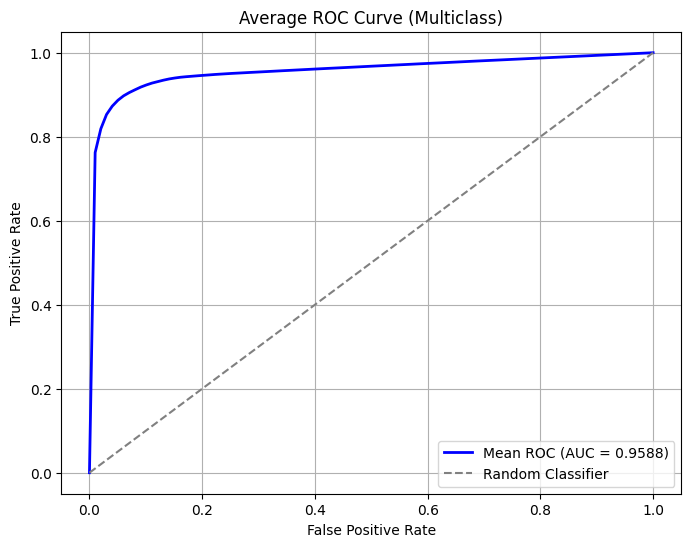

<ipython-input-15-8dd588cad3fc>:66: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


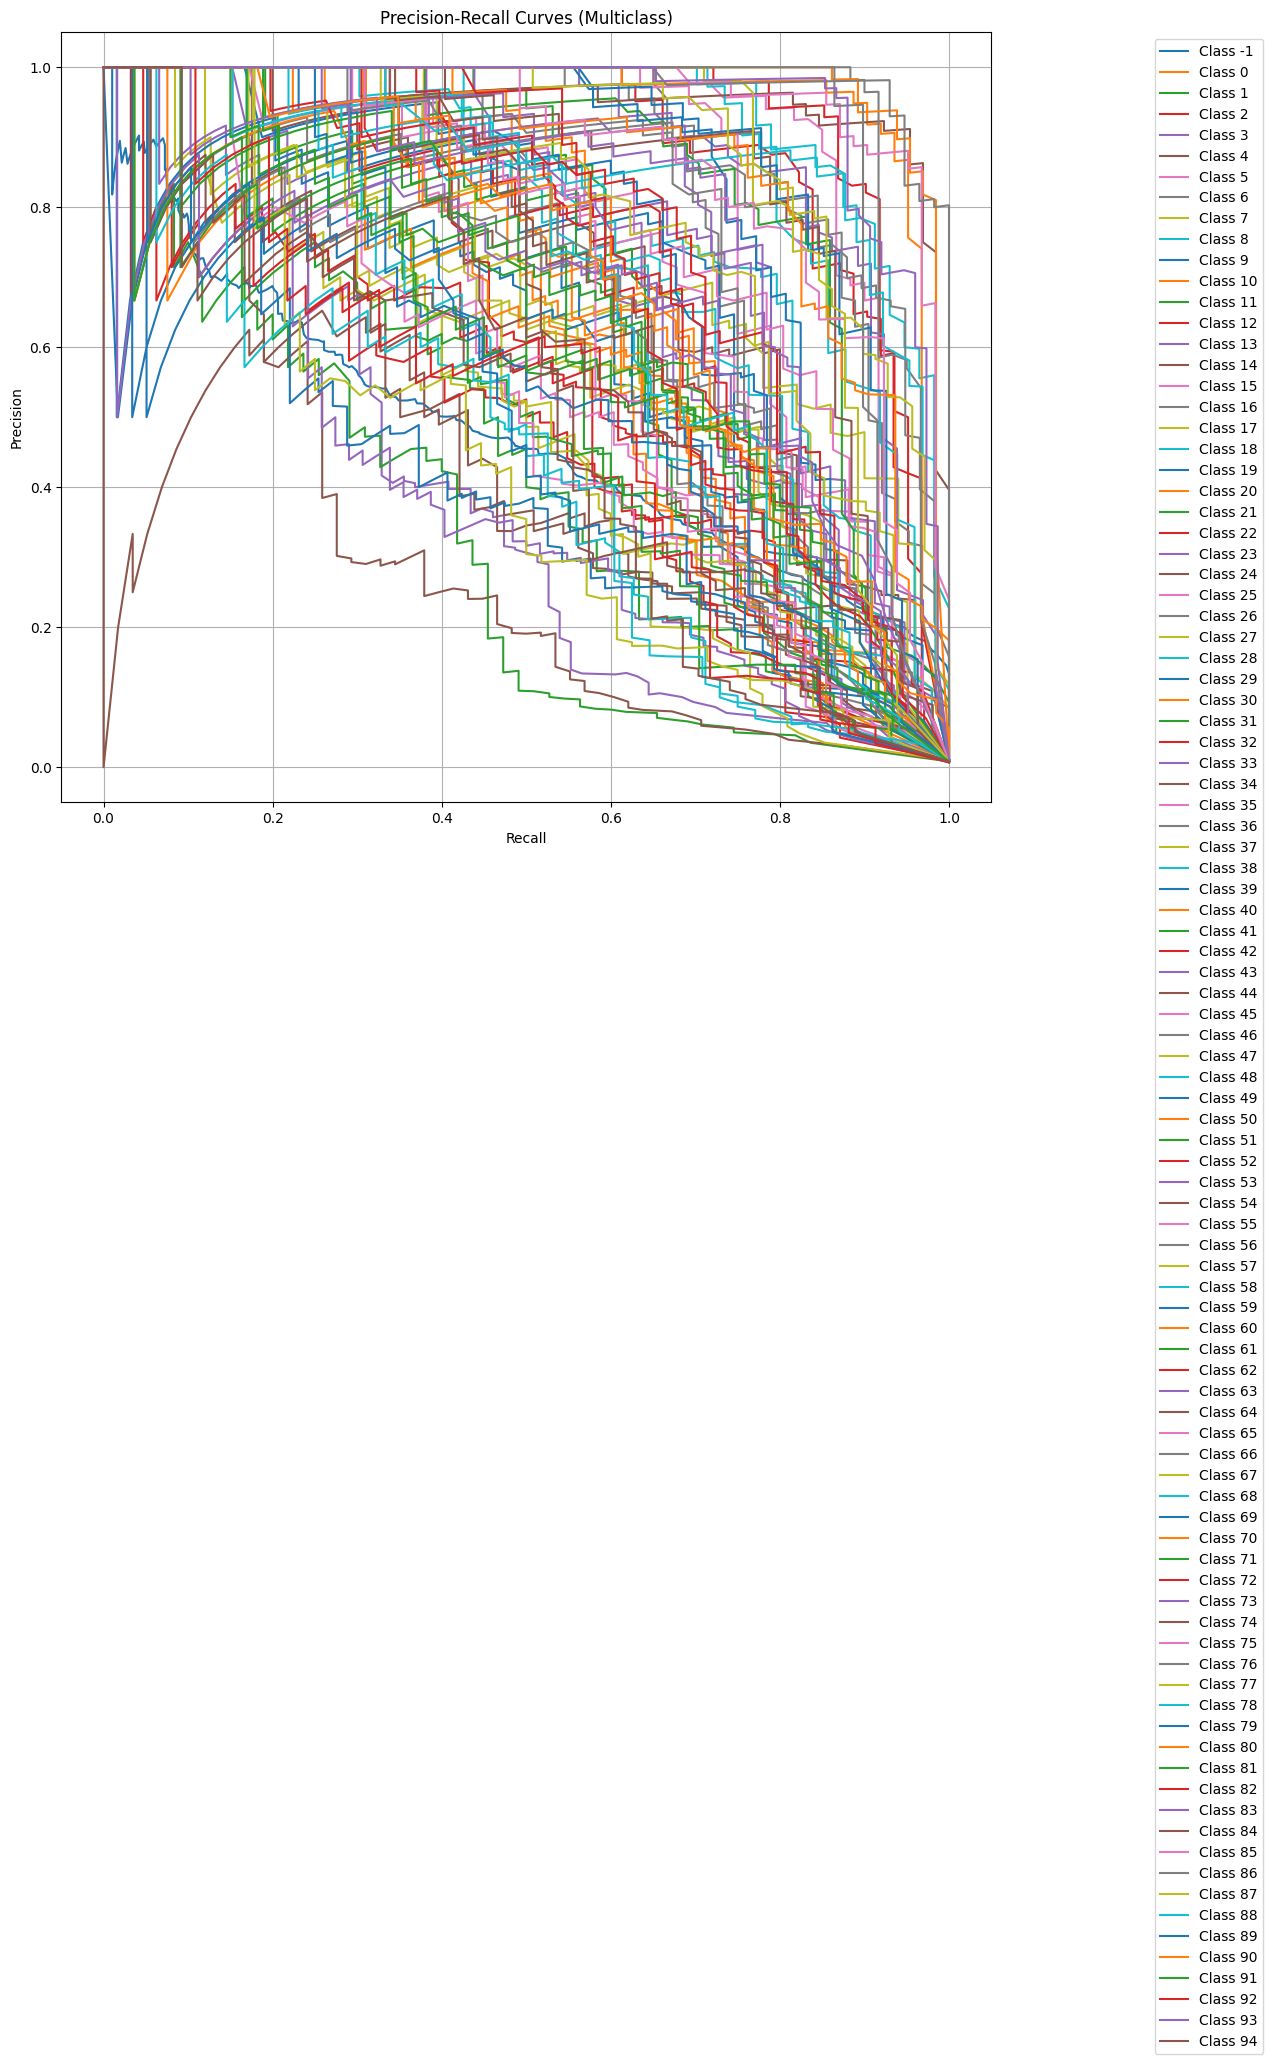

In [15]:
from sklearn.metrics import precision_recall_curve, roc_auc_score, classification_report, auc, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Classification Report
report = classification_report(y_test, y_pred)
print(report)

# 예측 확률값
y_pred_proba_best = best_model.predict_proba(X_test)

# 교차 검증 점수 계산
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='accuracy', n_jobs=-1)
print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean CV Accuracy: {np.mean(cv_scores):.4f} ± {np.std(cv_scores):.4f}")

# ROC Curve & avg AUC
fpr_avg = np.linspace(0, 1, 100)  # FPR 범위
tpr_list = []
roc_auc_list = []

for i, class_label in enumerate(best_model.classes_):
    # 각 클래스별 y_test 이진화
    binary_y_test = (y_test == class_label).astype(int)

    # FPR, TPR 계산
    fpr, tpr, _ = roc_curve(binary_y_test, y_pred_proba_best[:, i])
    tpr_interp = np.interp(fpr_avg, fpr, tpr)  # FPR에 대해 TPR 보간
    tpr_interp[0] = 0.0  # FPR = 0에서 TPR = 0
    tpr_list.append(tpr_interp)

    # AUC 계산
    roc_auc = auc(fpr, tpr)
    roc_auc_list.append(roc_auc)

# 평균 TPR 및 AUC 계산
mean_tpr = np.mean(tpr_list, axis=0)
mean_tpr[-1] = 1.0  # FPR = 1에서 TPR = 1
mean_auc = np.mean(roc_auc_list)

# ROC Curve 시각화
plt.figure(figsize=(8, 6))
plt.plot(fpr_avg, mean_tpr, color='blue', lw=2, label=f"Mean ROC (AUC = {mean_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier", color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Average ROC Curve (Multiclass)")
plt.legend(loc="lower right")
plt.grid()
plt.show()


# 2. 96 Precision-Recall Curves
plt.figure(figsize=(12, 10))

for i, class_label in enumerate(best_model.classes_):
    binary_y_test = (y_test == class_label).astype(int)
    precision_vals, recall_vals, _ = precision_recall_curve(binary_y_test, y_pred_proba_best[:, i])
    plt.plot(recall_vals, precision_vals, label=f"Class {class_label}")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves (Multiclass)")
plt.legend(loc="upper right", bbox_to_anchor=(1.3, 1))
plt.grid()
plt.tight_layout()
plt.show()
